In [1]:
import numpy as np
import pandas as pd
import keras
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import math

D:\zzyAnaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df=pd.read_csv("E:\git\dsmp-2024-group22\data_preprocess\DATA\processed_tapes.csv",parse_dates=['date'],index_col='date')
df=df.drop("Unnamed: 0",axis=1)
df=df.dropna()
df=df.sort_values(by='date')
df
# df['date'] = pd.to_datetime(df['date'])

,max_price,min_price,open_price,close_price
date,,,,
2025-01-02,303.0,243.0,267.0,288.0
2025-01-03,317.0,270.0,281.0,291.0
2025-01-06,346.0,276.0,278.0,327.0
2025-01-07,388.0,317.0,336.0,369.0
2025-01-08,374.0,303.0,365.0,311.0
...,...,...,...,...
2025-06-25,114.0,93.0,96.0,104.0
2025-06-26,114.0,94.0,113.0,111.0
2025-06-27,113.0,93.0,106.0,111.0


In [3]:
values=df.values
values=values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.6690141 , 0.66079295, 0.63837636, 0.6996337 ],
       [0.71830976, 0.7797357 , 0.6900369 , 0.71062267],
       [0.82042253, 0.80616736, 0.67896676, 0.8424908 ],
       [0.96830976, 0.9867841 , 0.8929889 , 0.99633694],
       [0.919014  , 0.9251101 , 1.        , 0.78388274],
       [0.89084506, 0.9118943 , 0.8191881 , 0.7875458 ],
       [0.7852112 , 0.80616736, 0.8376384 , 0.67399263],
       [0.84507036, 0.7929516 , 0.67896676, 0.9120879 ],
       [0.8661971 , 0.92951536, 0.9335793 , 0.93406594],
       [0.8661971 , 0.8634361 , 0.9667896 , 0.72893775],
       [0.73239434, 0.73568285, 0.74907744, 0.64835167],
       [0.7359154 , 0.75770926, 0.6937269 , 0.8205128 ],
       [0.919014  , 0.9251101 , 0.7712177 , 0.992674  ],
       [1.        , 0.9779736 , 0.9667896 , 0.8021978 ],
       [0.7922535 , 0.814978  , 0.86715865, 0.7252747 ],
       [0.6725352 , 0.753304  , 0.67896676, 0.6849817 ],
       [0.7007042 , 0.7621145 , 0.67896676, 0.68131864],
       [0.93309855, 0.7929516 ,

In [4]:
#定义series_to_supervised()函数
#将时间序列转换为监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5,6]],axis=1,inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
1,0.669014,0.660793,0.638376,0.699634,0.710623
2,0.718310,0.779736,0.690037,0.710623,0.842491
3,0.820423,0.806167,0.678967,0.842491,0.996337
4,0.968310,0.986784,0.892989,0.996337,0.783883
5,0.919014,0.925110,1.000000,0.783883,0.787546
...,...,...,...,...,...
120,0.000000,0.000000,0.062731,0.047619,0.025641
121,0.003521,0.000000,0.007380,0.025641,0.051282
122,0.003521,0.004405,0.070111,0.051282,0.051282
123,0.000000,0.000000,0.044280,0.051282,0.047619


In [6]:
# 划分训练集和测试集
values = reframed.values
train = np.concatenate([values[:50, :],values[75:,:]])
test = values[50:75, :]
# 划分训练集和测试集的输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#转化为三维数据
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(99, 1, 4) (99,)
(25, 1, 4) (25,)


In [7]:
test_X

array([[[0.3028169 , 0.35242292, 0.3394834 , 0.34432235]],

       [[0.31338027, 0.35242292, 0.35424355, 0.33333334]],

       [[0.38028166, 0.36563876, 0.36531368, 0.41758242]],

       [[0.38732395, 0.41409692, 0.40590408, 0.36996338]],

       [[0.33802816, 0.30837002, 0.3911439 , 0.2930403 ]],

       [[0.24999997, 0.24669603, 0.302583  , 0.21978024]],

       [[0.2147887 , 0.23348019, 0.2398524 , 0.25641027]],

       [[0.1971831 , 0.16740087, 0.2619926 , 0.16849819]],

       [[0.1338028 , 0.14977977, 0.21033213, 0.13186812]],

       [[0.15140846, 0.15418503, 0.19188192, 0.19413921]],

       [[0.14436617, 0.16740087, 0.21402213, 0.1831502 ]],

       [[0.16197184, 0.18061677, 0.2177122 , 0.19413921]],

       [[0.15492955, 0.15859029, 0.202952  , 0.1794872 ]],

       [[0.1338028 , 0.14537445, 0.19188192, 0.1758242 ]],

       [[0.16549292, 0.14977977, 0.12177122, 0.21611723]],

       [[0.18309858, 0.20264319, 0.17712179, 0.22710624]],

       [[0.20070425, 0.18942735, 0.24723

Epoch 1/50


D:\zzyAnaconda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 - 1s - 199ms/step - loss: 0.4127 - val_loss: 0.1869
Epoch 2/50
7/7 - 0s - 6ms/step - loss: 0.3799 - val_loss: 0.1584
Epoch 3/50
7/7 - 0s - 7ms/step - loss: 0.3422 - val_loss: 0.1312
Epoch 4/50
7/7 - 0s - 7ms/step - loss: 0.3119 - val_loss: 0.1084
Epoch 5/50
7/7 - 0s - 7ms/step - loss: 0.2902 - val_loss: 0.0882
Epoch 6/50
7/7 - 0s - 6ms/step - loss: 0.2571 - val_loss: 0.0708
Epoch 7/50
7/7 - 0s - 6ms/step - loss: 0.2299 - val_loss: 0.0550
Epoch 8/50
7/7 - 0s - 7ms/step - loss: 0.2108 - val_loss: 0.0440
Epoch 9/50
7/7 - 0s - 7ms/step - loss: 0.1840 - val_loss: 0.0370
Epoch 10/50
7/7 - 0s - 6ms/step - loss: 0.1696 - val_loss: 0.0360
Epoch 11/50
7/7 - 0s - 6ms/step - loss: 0.1470 - val_loss: 0.0376
Epoch 12/50
7/7 - 0s - 7ms/step - loss: 0.1175 - val_loss: 0.0414
Epoch 13/50
7/7 - 0s - 7ms/step - loss: 0.1041 - val_loss: 0.0445
Epoch 14/50
7/7 - 0s - 7ms/step - loss: 0.1099 - val_loss: 0.0463
Epoch 15/50
7/7 - 0s - 6ms/step - loss: 0.0947 - val_loss: 0.0452
Epoch 16/50
7/7 - 0s - 6ms/s

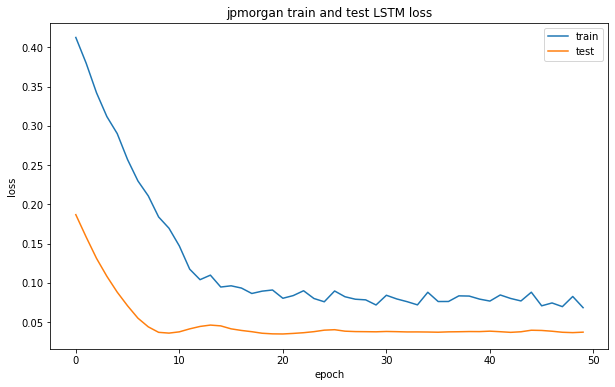

In [8]:
# 搭建LSTM模型
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1,activation='relu'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=16, validation_data=(test_X, test_y), verbose=2,shuffle=False)

# 绘制损失图
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('jpmorgan train and test LSTM loss', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [9]:
#模型预测收益率
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


In [10]:
# invert scaling for forecast
#将预测结果按比例反归一化
inv_y_test = np.concatenate((test_X[:, :3],y_predict), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]

# invert scaling for actual
#将真实结果按比例反归一化
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X[:, :3],test_y), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]
print('反归一化后的预测结果：',inv_y_predict)
print('反归一化后的真实结果：',inv_y)

反归一化后的预测结果： [183.88777 184.68697 195.90031 199.14178 182.54828 163.27267 159.00937
 149.12976 139.20012 143.25987 144.24681 147.10089 143.50119 140.49496
 141.50641 149.82355 152.745   147.49413 154.7678  143.41628 137.59212
 143.51414 139.13959 139.22406 143.07265]
反归一化后的真实结果： [188. 211. 198. 177. 157. 167. 143. 133. 150. 147. 150. 146. 145. 156.
 159. 155. 152. 163. 143. 142. 157. 139. 143. 142. 160.]


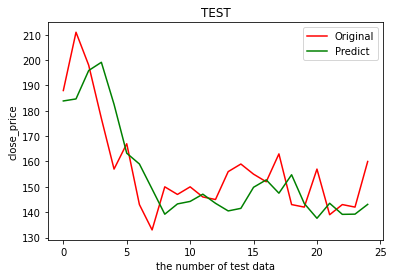

In [11]:
plt.plot(inv_y,color='red',label='Original')
plt.plot(inv_y_predict,color='green',label='Predict')
plt.xlabel('the number of test data')
plt.ylabel('close_price')
plt.title('TEST')
plt.legend()
plt.show()

D:\zzyAnaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\zzyAnaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


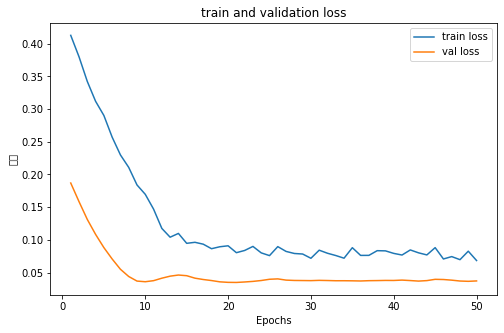

In [13]:
import matplotlib.pyplot as plt

# 假设 history 是模型训练过程的历史记录
# 提取训练损失和验证损失
train_loss = history.history['loss']
val_loss = history.history.get('val_loss', [])  # 如果有验证损失的话

# 创建损失变化图的横坐标，即每个epoch的编号
epochs_range = range(1, len(train_loss) + 1)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_loss, label='train loss')
if val_loss:  # 如果有验证集损失
    plt.plot(epochs_range, val_loss, label='val loss')

plt.title('train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('损失')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#回归评价指标
# calculate MSE 均方误差
mse=mean_squared_error(inv_y,inv_y_predict)
# calculate RMSE 均方根误差
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
#calculate MAE 平均绝对误差
mae=mean_absolute_error(inv_y,inv_y_predict)
#calculate R square
r_square=r2_score(inv_y,inv_y_predict)
print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)
print('MAE: %.6f' % mae)
print('R_square: %.6f' % r_square)

MSE: 168.604095
RMSE: 12.984764
MAE: 10.162806
R_square: 0.506303
